In [1]:
import pandas as pd

In [2]:
from sklearn.preprocessing import StandardScaler

def featuringData(user_data):
    user_data = user_data.drop(columns=['Unnamed: 0'])
    user_data['win'] = user_data['win'].fillna(0)  # Consider NaN in 'win' as 0 (loss)
    user_data['reason_to_die'] = user_data['reason_to_die'].fillna('none')  # Replace NaN with 'none' for categorical
    user_data = pd.get_dummies(user_data, columns=['event_name', 'mode_game', 'reason_to_die', 'version'], drop_first=True)

    # Aggregate data per user to create features
    user_features = user_data.groupby('user').agg({
        'date_time': 'count',  # Total number of events
        'level': ['nunique', 'mean'],  # Number of unique levels played and average level
        'day_diff': 'mean',  # Average day_diff
        'win': 'sum',  # Total number of wins
        'quantity': 'sum'  # Total quantity used
    }).reset_index()
    user_features.columns = ['user', 'total_events', 'unique_levels', 'avg_level', 'avg_day_diff', 'total_wins', 'total_quantity']

    return user_features

In [3]:
from sklearn.cluster import KMeans
# Training Data
user_data = pd.read_csv('data_example.csv')
featuredData = featuringData(user_data)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(featuredData.drop(columns=['user']))

# K-means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_features)


# Test Data
df_test = pd.read_csv('test.csv')
testFeaturedData = featuringData(df_test)

# Ensure consistent feature encoding and scaling for test data
testFeaturedData = testFeaturedData.reindex(columns=featuredData.columns, fill_value=0)  
scaled_test_features = scaler.transform(testFeaturedData.drop(columns=['user']))

# Prediction
test_predictions = pd.DataFrame({'user': testFeaturedData['user'],
                                 'cluster': kmeans.predict(scaled_test_features)})

print(test_predictions) 

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                                   user  cluster
0  a89e7ea9-c8bb-4695-a4e2-90b7c0cfb2ca        0


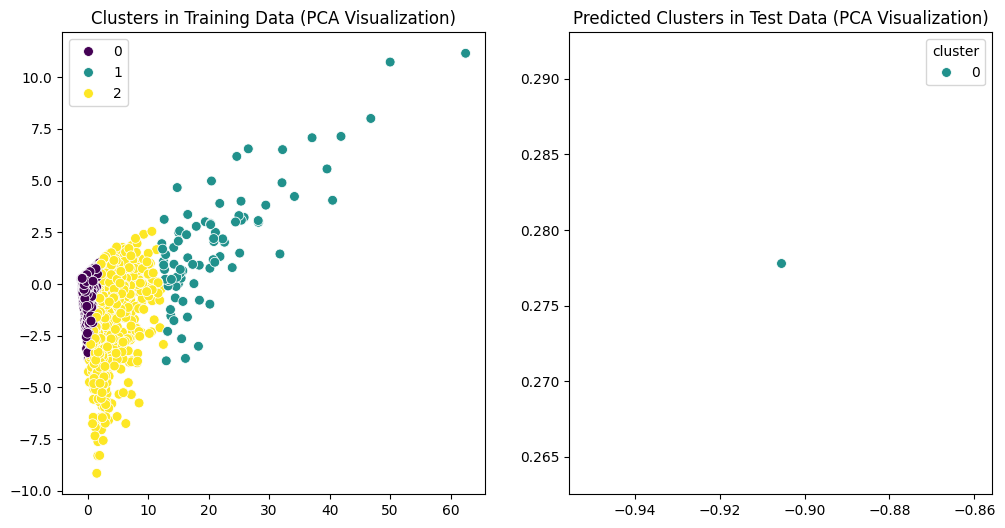

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


# Dimensionality Reduction with PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
reduced_features = pca.fit_transform(scaled_features)
reduced_test_features = pca.transform(scaled_test_features)


# Visualization
plt.figure(figsize=(12, 6))


# Plot training data (clusters from original dataset)
plt.subplot(1, 2, 1)
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=kmeans.labels_, palette='viridis', s=50)
plt.title('Clusters in Training Data (PCA Visualization)')


# Plot test data (predicted clusters)
plt.subplot(1, 2, 2)
sns.scatterplot(x=reduced_test_features[:, 0], y=reduced_test_features[:, 1], hue=test_predictions['cluster'], palette='viridis', s=50)
plt.title('Predicted Clusters in Test Data (PCA Visualization)')

plt.show()
